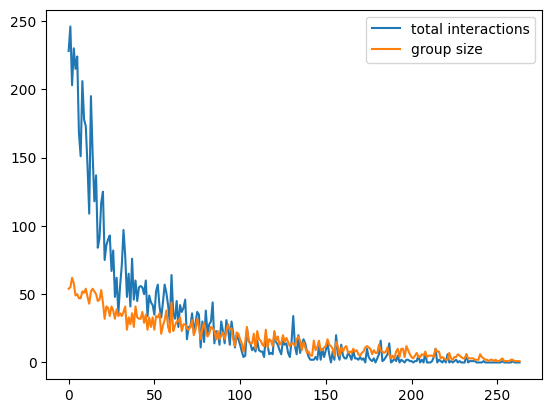

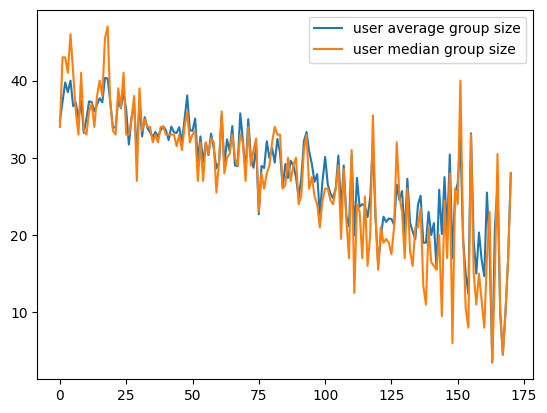

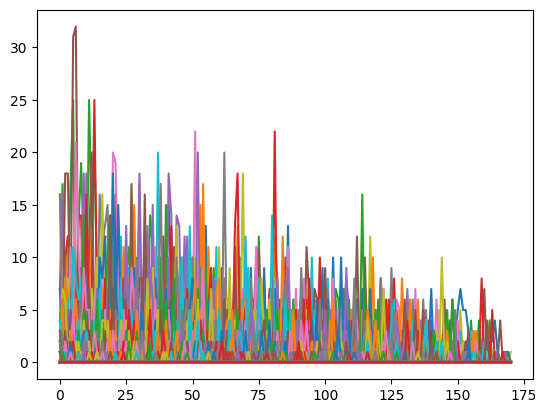

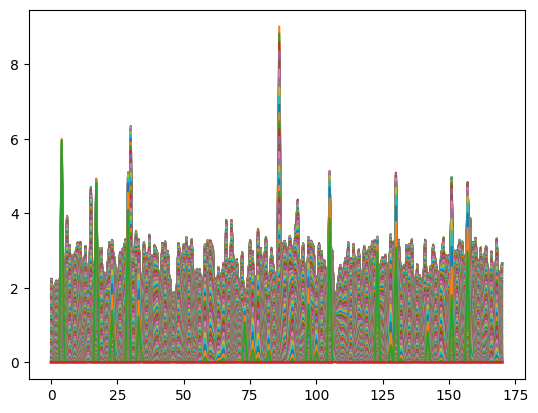

In [17]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
from math import floor

class Group:
    def __init__(self):
        # Initialize a group with an ID and a dictionary to track user interactions
        self.id = 0
        self.interactions = {}

class User:
    def __init__(self, alpha, beta):
        # Initialize a user with ID, group memberships, interaction history, and Beta distribution preferences
        self.id = 0
        self.groups = []
        self.interaction_history = []
        self.preferences = stats.beta(alpha, beta)

    def update_preferences(self):
        # Update user's preferences based on group interactions
        if not self.groups:
            self.updated_preferences = np.array([1])
            return

        total_size = sum([len(group.interactions) for group in self.groups])
        if total_size == 0:
            self.groups_cdf = np.array([1 / len(self.groups)] * len(self.groups))
        else:
            self.groups_cdf = np.array(sorted([len(group.interactions) / total_size for group in self.groups])[::-1])

        self.updated_preferences = np.convolve(self.preferences.pdf(np.linspace(0, 1, len(self.groups))), self.groups_cdf, mode='same')

        if np.isnan(self.updated_preferences).any() or np.sum(self.updated_preferences) == 0:
            self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
        else:
            self.updated_preferences /= np.sum(self.updated_preferences)

    def join_group(self, group):
        # Add a group to the user's group list and set initial interactions to 0
        self.groups.append(group)
        group.interactions[self] = 0

    def interact(self, group: Group):
        # Record an interaction with the specified group
        group.interactions[self] += 1
        self.interaction_history.append(group.id)

# Initialize lists to store users and groups
users = []
groups = []
num_groups = len(groups)

# Define simulation parameters
user_growth_rate = 1
new_group_join_rate = 0.0625
new_group_threshold = 0.05
interaction_threshold = 1
num_timesteps = 100
alpha_hyperparameter = 10
beta_hyperparameter = 10 
initial_users = 10
initial_groups = 5


# Data structure for regression analysis
data_for_regression = []

# Create initial users and groups
for _ in range(initial_users):
    user = User(np.random.uniform(1, alpha_hyperparameter), np.random.uniform(1, beta_hyperparameter))
    users.append(user)
    user.id = len(users)

for _ in range(initial_groups):
    group = Group()
    groups.append(group)
    group.id = len(groups)

# Initial user-group interactions
for user in users:
    for _ in range(floor(stats.expon.rvs(new_group_join_rate))):
        group = np.random.choice(groups)
        user.join_group(group)
    user.update_preferences()

# Main simulation loop
for _ in range(num_timesteps):
    for _ in range(floor(stats.expon.rvs(user_growth_rate))): 
        user = User(np.random.uniform(1, alpha_hyperparameter), np.random.uniform(1, beta_hyperparameter))
        users.append(user)
        user.id = len(users)

    for user in users:
        for _ in range(floor(stats.expon.rvs(new_group_join_rate))):
            if np.random.uniform() < new_group_threshold:
                group = Group()
                user.join_group(group)
                groups.append(group)
                group.id = len(groups)
            else:
                group = np.random.choice(groups)
                user.join_group(group)

        if user.groups:
            user.update_preferences()
        else:
            user.updated_preferences = np.array([1])

        num_groups = len(groups)

        if np.random.uniform() < interaction_threshold and user.groups:
            group = np.random.choice(user.groups, p=user.updated_preferences)
            user.interact(group)
            current_group = user.interaction_history[-1]
        else:
            user.interaction_history.append(0)
            current_group = user.interaction_history[-1]

        if len(user.interaction_history) > 1:
            previous_group = user.interaction_history[-2]
            interactions_by_group = np.bincount(user.interaction_history, minlength=num_groups)
            data_for_regression.append([user.id, current_group, previous_group, *interactions_by_group])
        else:
            previous_group = current_group
            interactions_by_group = np.bincount(user.interaction_history, minlength=num_groups)
            data_for_regression.append([user.id, current_group, previous_group, *interactions_by_group])

plt.plot([sum(groups[i].interactions.values()) for i in range(len(groups))], label='total interactions')
plt.plot([len(groups[i].interactions) for i in range(len(groups))], label='group size')
plt.legend()
plt.show()

plt.plot([np.mean([len(group.interactions) for group in users[user - 1].groups])for user in list([user.id for user in users])], label='user average group size')
plt.plot([np.median([len(group.interactions) for group in users[user - 1].groups])for user in list([user.id for user in users])], label='user median group size')
plt.legend()
plt.show()

plt.plot([np.bincount(users[i].interaction_history, minlength=num_groups) for i in range(len(users))], label='user interactions by group')
plt.show()

plt.plot([user.preferences.pdf(np.linspace(0, 1, num_groups)) for user in users], label='user preferences')
plt.show()

df = pd.DataFrame(data_for_regression, columns=['user_id', 'current_group', 'previous_group', *[f'group_{i}' for i in range(num_groups)]])
df = df.fillna(0)
df.to_csv('data_for_regression.csv')
